# ЛАБОРАТОРНАЯ РАБОТА №6. «ОБУЧЕНИЕ БЕЗ УЧИТЕЛЯ. ЗАДАЧА КЛАСТЕРИЗАЦИИ»

In [1]:
from pprint import pprint
import warnings

from scipy.cluster import hierarchy
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, KMeans
from sklearn.datasets import make_classification, make_blobs
from sklearn.metrics import silhouette_score, calinski_harabasz_score, jaccard_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn_som.som import SOM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE


warnings.filterwarnings('ignore')

## Задание №1.

### 1. Сгенерировать 3 датасета (make_classification или make_blobs)

In [2]:
X1, y1 = make_classification(n_samples=999, n_classes=2, n_features=2, n_redundant=0, n_clusters_per_class=2, flip_y=0, random_state=111)
X2, y2 = make_blobs(n_samples=666, n_features=4, random_state=222)
X3, y3 = make_classification(n_samples=333, n_classes=4, n_features=8, n_clusters_per_class=4, random_state=333, n_informative=4)

### 2. Провести визуализацию

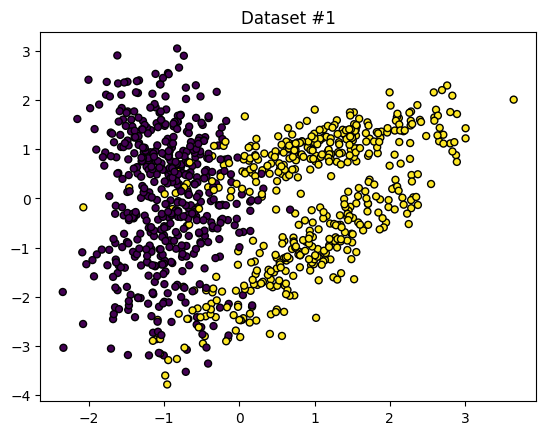

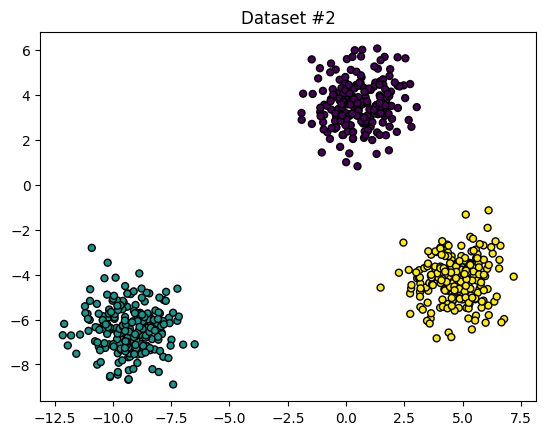

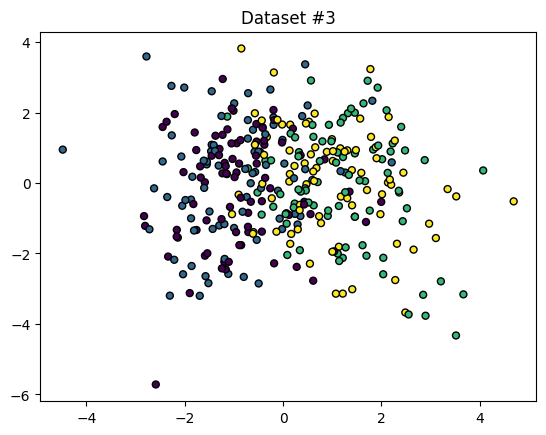

In [3]:
X = X1, X2, X3
y = y1, y2, y3

for i in range(3):
    plt.scatter(X[i][:, 0], X[i][:, 1], marker="o", c=y[i], s=25, edgecolor="k")
    plt.title(f'Dataset #{i+1}')    
    plt.show()

### 3. Провести кластеризацию (все методы)

In [4]:
def metrics(X, y, labels):
  return {
    'Rand': rand_score(y, labels),
    'Jaccard': jaccard_score(y, labels, average='micro'),
    'Silhouette': silhouette_score(X, labels),
    'Calinski-Harabasz': calinski_harabasz_score(X, labels)
  }

def best_method(methods, metrics):
    return max([(val[metrics], k) for k, val in methods.items()])

methods = [{}, {}, {}]

#### KMeans

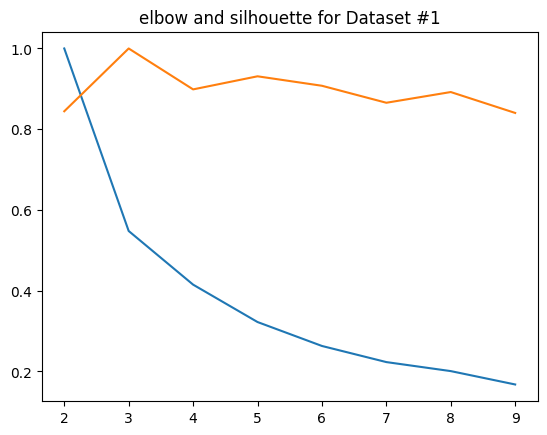

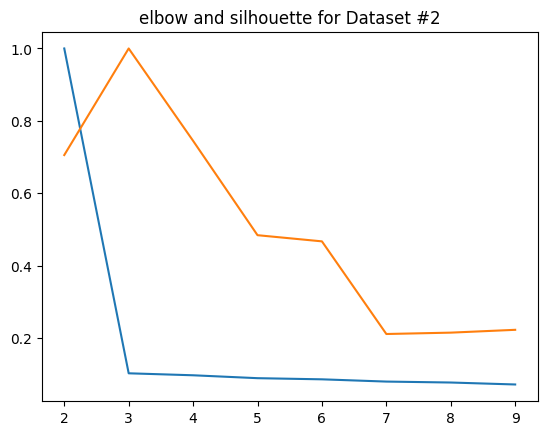

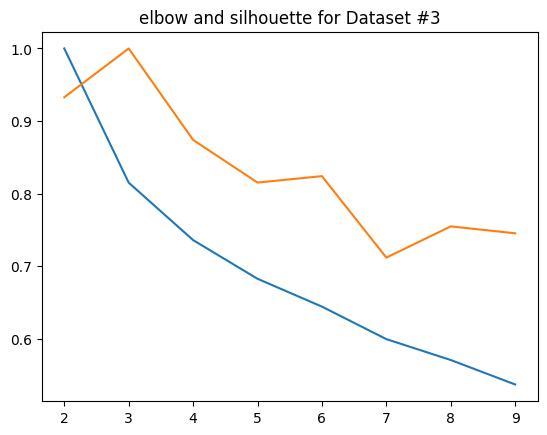

In [5]:
for i in range(3):
    inertias = []
    ss = []
    for n_ in range(2, 10):
        inertias.append(KMeans(n_, n_init='auto').fit(X[i]).inertia_)
        ss.append(silhouette_score(X[i], KMeans(n_, n_init='auto').fit(X[i]).labels_))
    
    plt.title(f'elbow and silhouette for Dataset #{i+1}')
    plt.plot(range(2,10), np.divide(inertias, max(inertias)))
    plt.plot(range(2,10), np.divide(ss, max(ss)))
    plt.show()

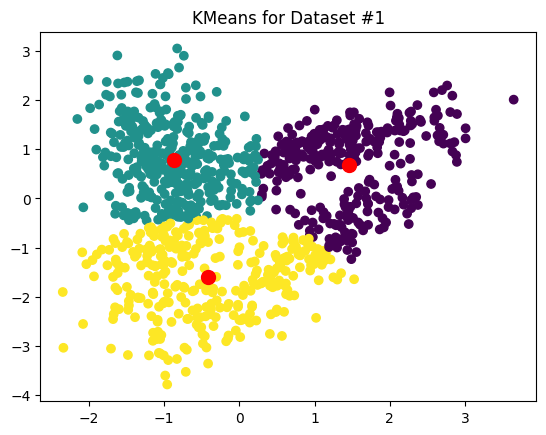

{'Calinski-Harabasz': 1053.7546457540998,
 'Jaccard': 0.026194144838212634,
 'Rand': 0.6658020746197099,
 'Silhouette': 0.44510771733489735}


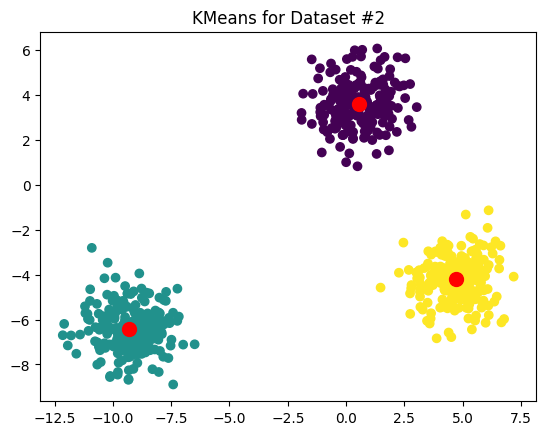

{'Calinski-Harabasz': 6498.547798032284,
 'Jaccard': 1.0,
 'Rand': 1.0,
 'Silhouette': 0.8168063497288396}


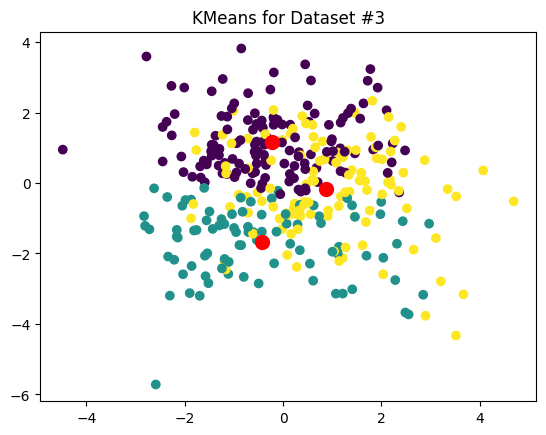

{'Calinski-Harabasz': 91.49567059387051,
 'Jaccard': 0.18294849023090587,
 'Rand': 0.590524259198958,
 'Silhouette': 0.19788750621078174}


In [6]:
n = (3, 3, 3)
for i in range(3):
    kmeans = KMeans(n[i], n_init='auto').fit(X[i])

    plt.title(f'KMeans for Dataset #{i+1}')
    plt.scatter(X[i][:,0], X[i][:,1], c=kmeans.labels_)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')
    plt.show()

    methods[i]['KMeans'] = metrics(X[i], y[i], kmeans.labels_)
    pprint(metrics(X[i], y[i], kmeans.labels_))

#### AffinityPropagation

In [7]:
for i in range(3):
    ss = []
    for dp in np.arange(0.5, 0.9, 0.05):
        ss.append((silhouette_score(X[i], AffinityPropagation(damping=dp).fit(X[i]).labels_), dp))
    
    print(max(ss))

(0.3586632038937028, 0.8500000000000003)
(0.6084689903914381, 0.8500000000000003)
(0.15361868718739283, 0.55)


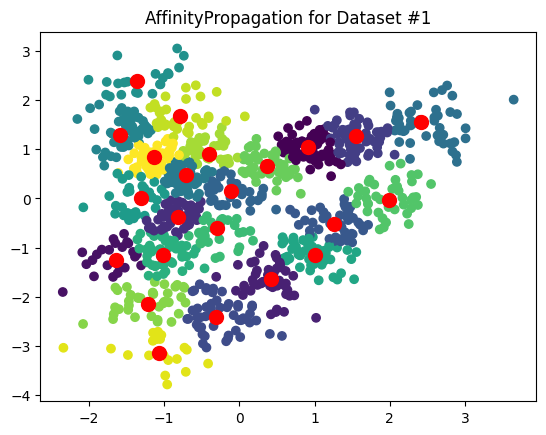

{'Calinski-Harabasz': 1107.283720411182,
 'Jaccard': 0.0,
 'Rand': 0.5379186802032493,
 'Silhouette': 0.35894643469198406}


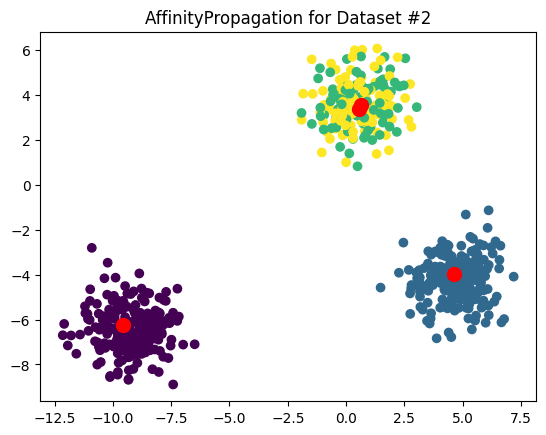

{'Calinski-Harabasz': 4665.4456179635645,
 'Jaccard': 0.0,
 'Rand': 0.945011176590124,
 'Silhouette': 0.6084689903914381}


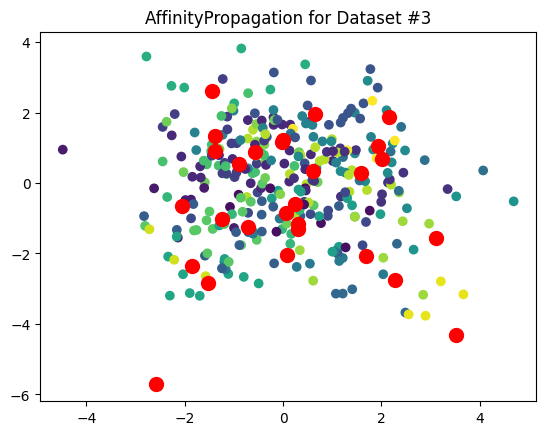

{'Calinski-Harabasz': 32.896583499132106,
 'Jaccard': 0.01524390243902439,
 'Rand': 0.7496291472195087,
 'Silhouette': 0.15361868718739283}


In [8]:
damping = (0.83, 0.98, 0.57)
for i in range(3):
    AP = AffinityPropagation(damping=damping[i]).fit(X[i])

    plt.title(f'AffinityPropagation for Dataset #{i+1}')
    plt.scatter(X[i][:,0], X[i][:,1], c=AP.labels_)
    plt.scatter(AP.cluster_centers_[:,0], AP.cluster_centers_[:,1], s=100, c='red')
    plt.show()

    methods[i]['AffinityPropagation'] = metrics(X[i], y[i], AP.labels_)
    pprint(metrics(X[i], y[i], AP.labels_))

#### DBSCAN

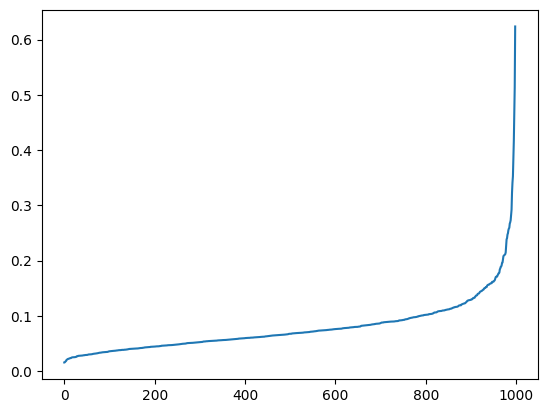

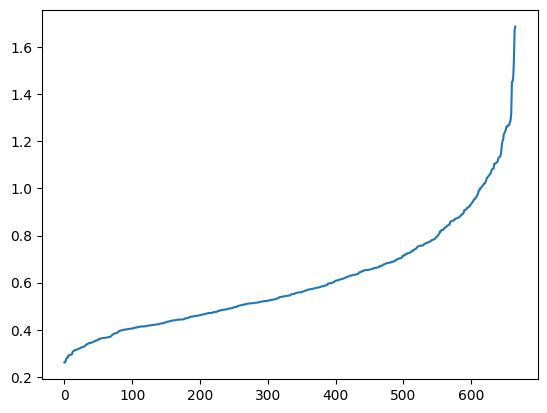

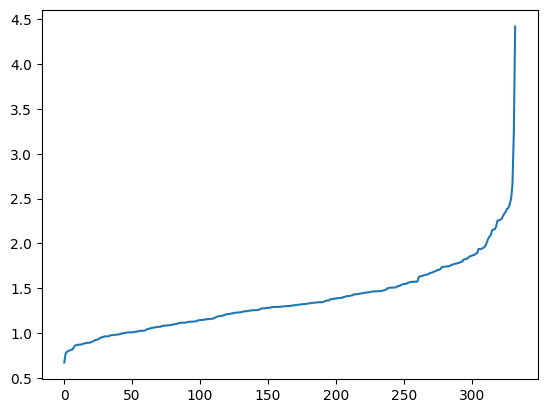

In [9]:
for i in range(3):
    nbrs = NearestNeighbors(n_neighbors=4).fit(X[i])
    distances, indices = nbrs.kneighbors(X[i])
    distances = np.sort(np.mean(distances, axis=1))
    plt.plot(distances)
    plt.show()

In [10]:
eps = (0.2, 1.0, 2.0)
for i in range(3):
    ss = []
    for min_s in range(2, 16):
        ss.append((silhouette_score(X[i], DBSCAN(eps=eps[i], min_samples=min_s).fit(X[i]).labels_), min_s))
        
    print(max(ss))

(0.19158991995594316, 10)
(0.4088755841973317, 6)
(0.13086159670724354, 6)


[-1  0  1  2]


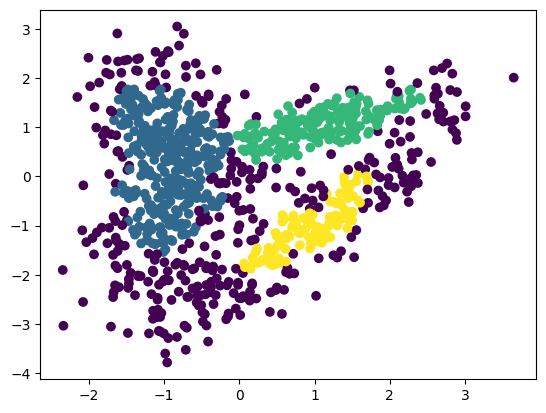

{'Calinski-Harabasz': 162.58610523400418,
 'Jaccard': 0.33111259160559625,
 'Rand': 0.6321973275881092,
 'Silhouette': 0.19158991995594316}
[-1  0  1  2]


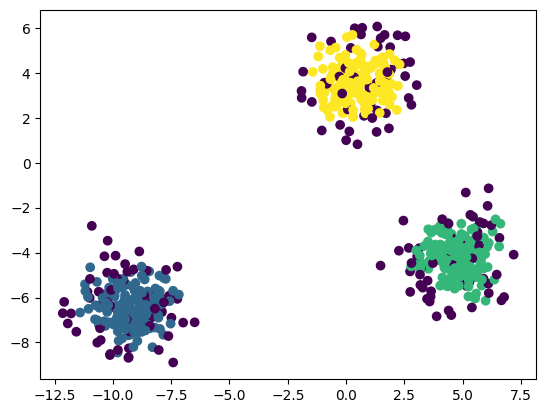

{'Calinski-Harabasz': 528.5140533780933,
 'Jaccard': 0.0,
 'Rand': 0.827763101447312,
 'Silhouette': 0.4088755841973317}
[-1  0]


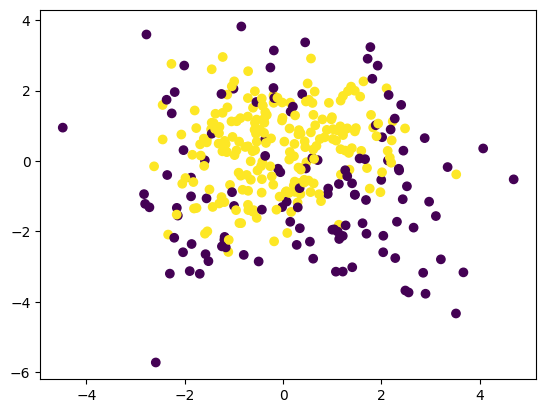

{'Calinski-Harabasz': 12.435845324805866,
 'Jaccard': 0.09539473684210527,
 'Rand': 0.48344730272441117,
 'Silhouette': 0.13086159670724354}


In [11]:
min_samples = (10, 6, 6)
for i in range(3):
    dbscan = DBSCAN(eps=eps[i], min_samples=min_samples[i]).fit(X[i])
    print(np.unique(dbscan.labels_))
    plt.scatter(X[i][:,0], X[i][:,1], c=dbscan.labels_)
    plt.show()

    methods[i]['DBSCAN'] = metrics(X[i], y[i], dbscan.labels_)
    pprint(metrics(X[i], y[i], dbscan.labels_))


#### GaussianMixture

In [12]:
for i in range(3):
    ss = []
    for n_ in range(2, 10):
        ss.append((silhouette_score(X[i], GaussianMixture(n_components=n_).fit_predict(X[i])), n_))
    print(max(ss))

(0.399179398351828, 5)
(0.8168063497288396, 3)
(0.19108231787047794, 2)


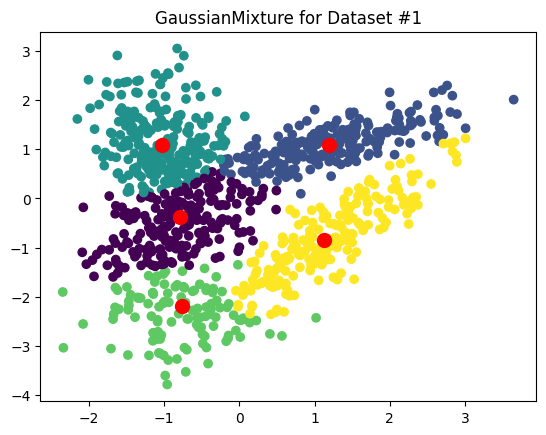

{'Calinski-Harabasz': 888.5555680479853,
 'Jaccard': 0.2589792060491493,
 'Rand': 0.6598101107119143,
 'Silhouette': 0.3982630334085318}


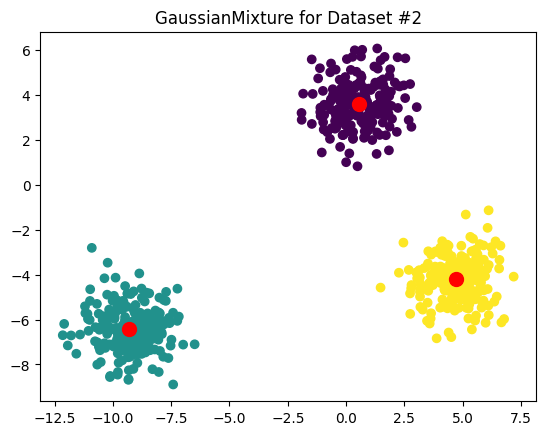

{'Calinski-Harabasz': 6498.547798032284,
 'Jaccard': 1.0,
 'Rand': 1.0,
 'Silhouette': 0.8168063497288396}


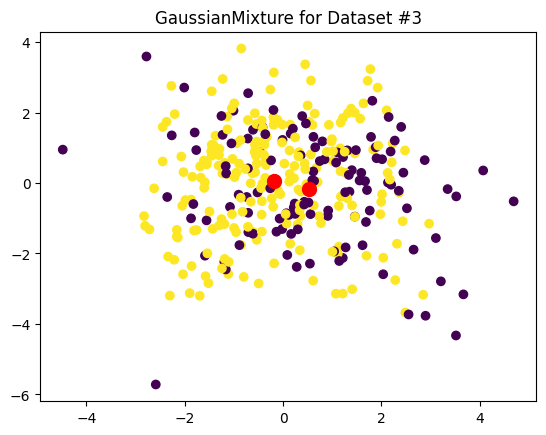

{'Calinski-Harabasz': 71.9698803750505,
 'Jaccard': 0.16637478108581435,
 'Rand': 0.4857266905459677,
 'Silhouette': 0.17793099332858972}


In [13]:
n_components = (5, 3, 2)
for i in range(3):
    GM = GaussianMixture(n_components=n_components[i]).fit(X[i])

    plt.title(f'GaussianMixture for Dataset #{i+1}')
    plt.scatter(X[i][:,0], X[i][:,1], c=GM.predict(X[i]))
    plt.scatter(GM.means_[:,0], GM.means_[:,1], s=100, c='red')
    plt.show()

    methods[i]['GaussianMixture'] = metrics(X[i], y[i], GM.predict(X[i]))
    pprint(metrics(X[i], y[i], GM.predict(X[i])))

#### hierarchy

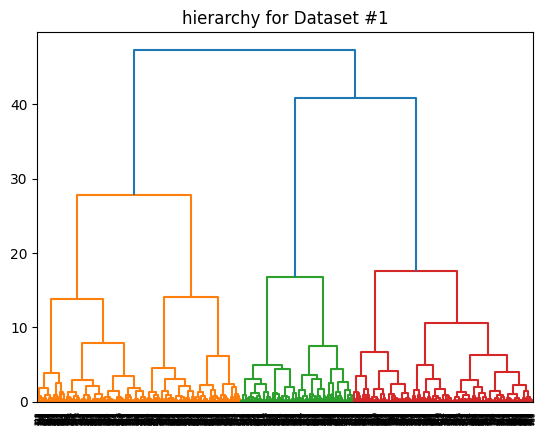

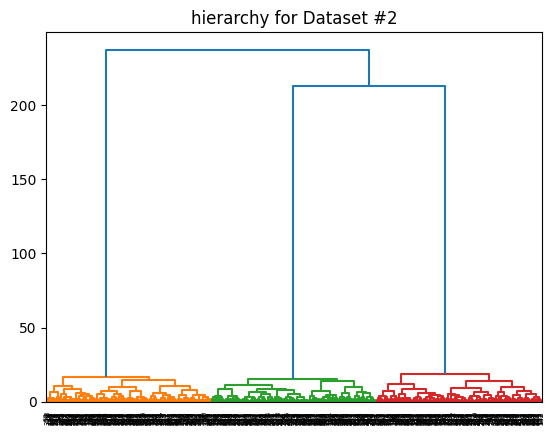

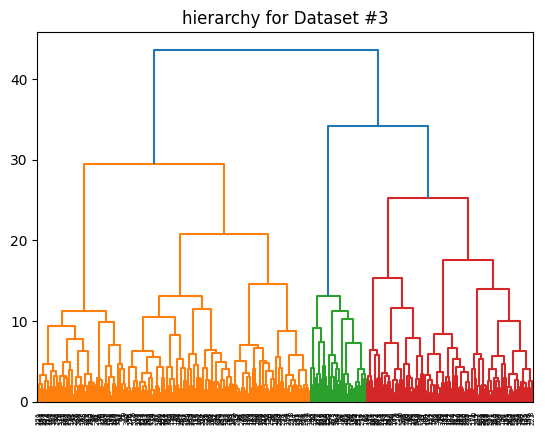

In [14]:
for i in range(3):
    plt.title(f'hierarchy for Dataset #{i+1}')
    dendrogram = hierarchy.dendrogram(hierarchy.linkage(X[i], method="ward"))
    plt.show()

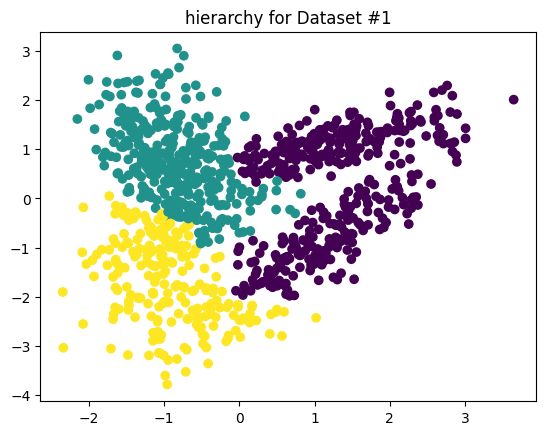

{'Calinski-Harabasz': 759.1376285980972,
 'Jaccard': 0.019908116385911178,
 'Rand': 0.7584398025279789,
 'Silhouette': 0.3770552498572616}


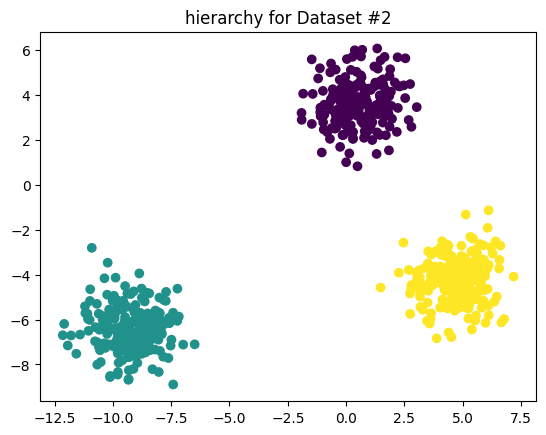

{'Calinski-Harabasz': 6498.547798032284,
 'Jaccard': 1.0,
 'Rand': 1.0,
 'Silhouette': 0.8168063497288396}


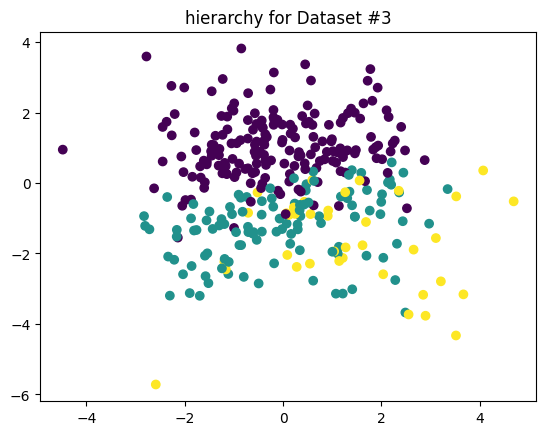

{'Calinski-Harabasz': 68.21142011365488,
 'Jaccard': 0.16230366492146597,
 'Rand': 0.5470530771735591,
 'Silhouette': 0.17091532256349112}


In [15]:
n = (3, 3, 3)
for i in range(3):
    AC = AgglomerativeClustering(n_clusters=n[i], linkage="ward").fit(X[i])

    plt.title(f'hierarchy for Dataset #{i+1}')
    plt.scatter(X[i][:,0], X[i][:,1], c=AC.labels_)
    plt.show()

    methods[i]['hierarchy'] = metrics(X[i], y[i], AC.fit_predict(X[i]))
    pprint(metrics(X[i], y[i], AC.fit_predict(X[i])))

#### SOM

In [16]:
for i in range(3):
    ss = []
    for m in range(2,5):
        for n in range(2,5):
            _, dim = X[i].shape
            ss.append((silhouette_score(X[i], SOM(m=m, n=n, dim=dim).fit_predict(X[i])), m, n))
    print(max(ss))  

(0.42577893910305586, 2, 2)
(0.8168063497288396, 3, 2)
(0.16343539408608687, 2, 2)


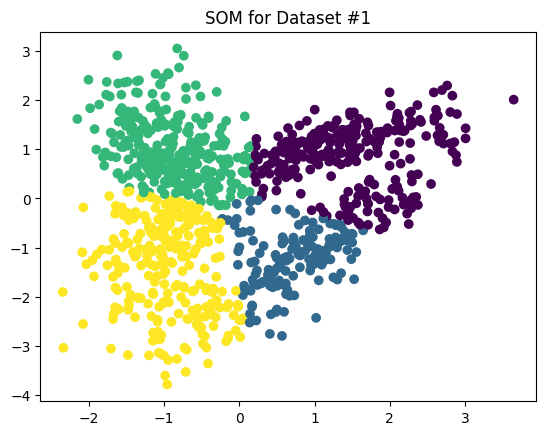

{'Calinski-Harabasz': 975.9982734716787,
 'Jaccard': 0.016793893129770993,
 'Rand': 0.65934471545694,
 'Silhouette': 0.418776133397}


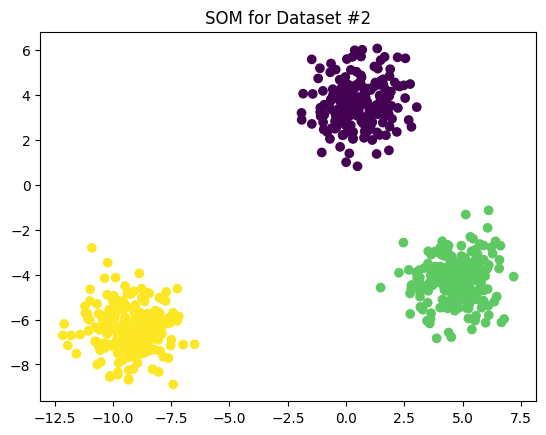

{'Calinski-Harabasz': 6498.547798032284,
 'Jaccard': 0.2,
 'Rand': 1.0,
 'Silhouette': 0.8168063497288396}


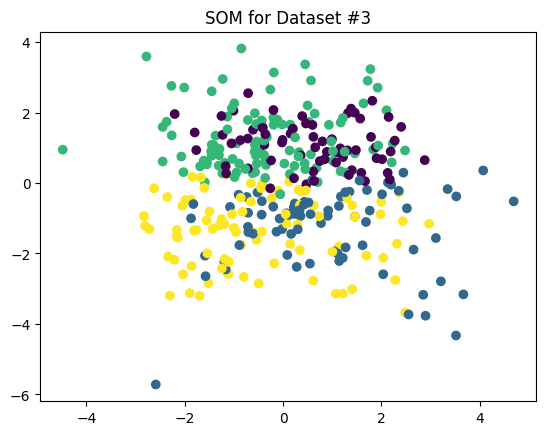

{'Calinski-Harabasz': 71.4363247646568,
 'Jaccard': 0.10082644628099173,
 'Rand': 0.6479612142262745,
 'Silhouette': 0.14712851430614884}


In [17]:
m_n =((2, 2), (3, 2), (2, 2))
for i in range(3):
    _, dim = X[i].shape
    m, n = m_n[i]
    som = SOM(m=m, n=n, dim=dim)
    plt.title(f'SOM for Dataset #{i+1}')
    plt.scatter(X[i][:,0], X[i][:,1], c=som.fit_predict(X[i]))
    plt.show()

    methods[i]['SOM'] = metrics(X[i], y[i], som.fit_predict(X[i]))
    pprint(metrics(X[i], y[i], som.fit_predict(X[i])))

### 4. Для каждого метода подобрать оптимальные гиперпараметры.

### 5. Самостоятельно реализовать KMeans. Проверить его работу на датасетах.

In [18]:
def Kmeans(X, k, max_iters=100):
    # Инициализация центроидов случайным образом
    centroids = X[np.random.choice(range(X.shape[0]), size=k, replace=False)]
    
    for _ in range(max_iters):
        # Нахождение ближайшего центроида для каждой точки
        labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=1)
        
        # Обновление центроидов
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Проверка на сходимость
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

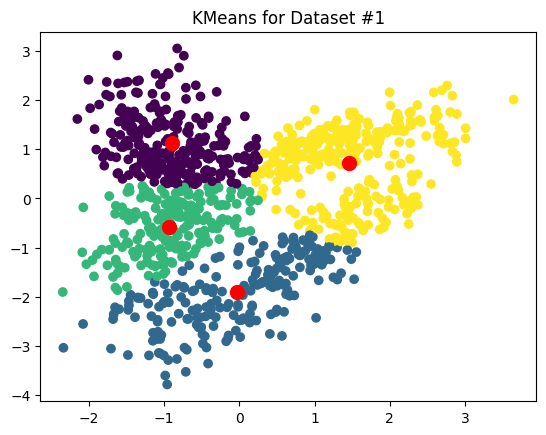

{'Calinski-Harabasz': 945.9443498866156,
 'Jaccard': 0.24408468244084683,
 'Rand': 0.6685402837707447,
 'Silhouette': 0.39970160890397466}


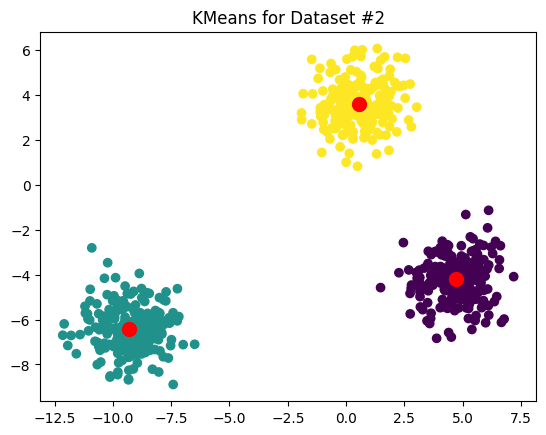

{'Calinski-Harabasz': 6498.547798032284,
 'Jaccard': 0.2,
 'Rand': 1.0,
 'Silhouette': 0.8168063497288396}


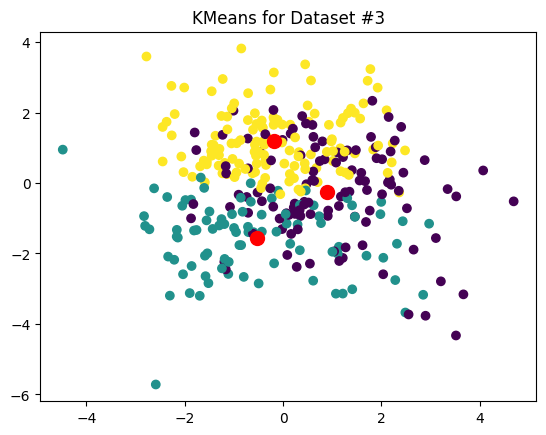

{'Calinski-Harabasz': 91.55863090132509,
 'Jaccard': 0.1522491349480969,
 'Rand': 0.590976518687362,
 'Silhouette': 0.1965291170555342}


In [19]:
k = (4, 3, 3)
for i in range(3):
    labels, centroids = Kmeans(X[i], k[i])

    plt.title(f'KMeans for Dataset #{i+1}')
    plt.scatter(X[i][:,0], X[i][:,1], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], s=100, c='red')
    plt.show()

    pprint(metrics(X[i], y[i], labels))

### 6. Каждый метод оценивать 2 внешними и 2 внутренними метриками.

In [20]:
for i in range(3):
    print(best_method(methods[i], 'Silhouette'))

# pprint(methods)

(0.44510771733489735, 'KMeans')
(0.8168063497288396, 'hierarchy')
(0.19788750621078174, 'KMeans')



## Задание №2.

### 1. На основе датасета для задачи классификации построить модель кластеризации, используя три метода:

In [21]:
dfc = pd.read_csv('../data/neo_task_upd.csv')[:5000]

yc = dfc['hazardous']
Xc = dfc.drop(['hazardous'], axis=1)

models = {}

In [22]:
smote = SMOTE()
Xc, yc = smote.fit_resample(Xc, yc)

scaler = StandardScaler()
Xc = scaler.fit_transform(Xc)


#### k-means

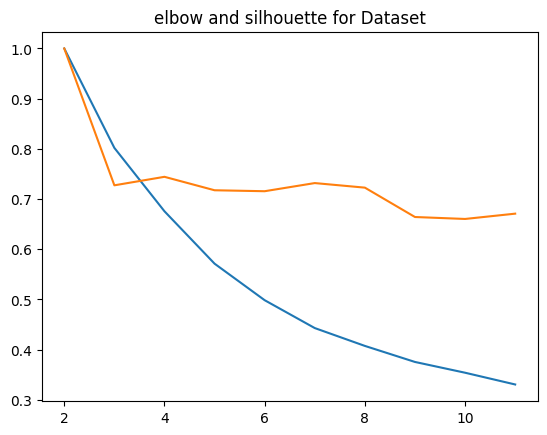

In [23]:
inertias = []
ss = []
rng = range(2, 12)

for n_ in rng:
    inertias.append(KMeans(n_, n_init='auto').fit(Xc).inertia_)
    ss.append(silhouette_score(Xc, KMeans(n_, n_init='auto').fit(Xc).labels_))

plt.title(f'elbow and silhouette for Dataset')
plt.plot(rng, np.divide(inertias, max(inertias)))
plt.plot(rng, np.divide(ss, max(ss)))
plt.show()

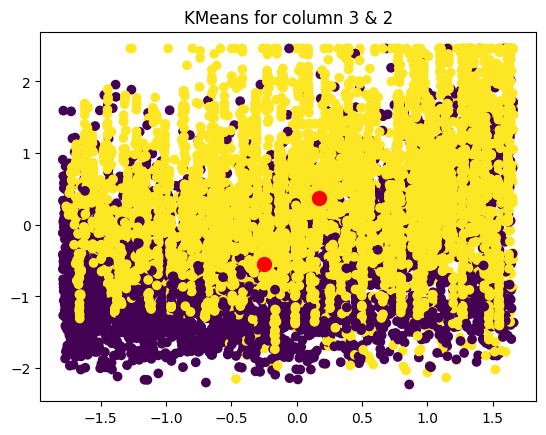

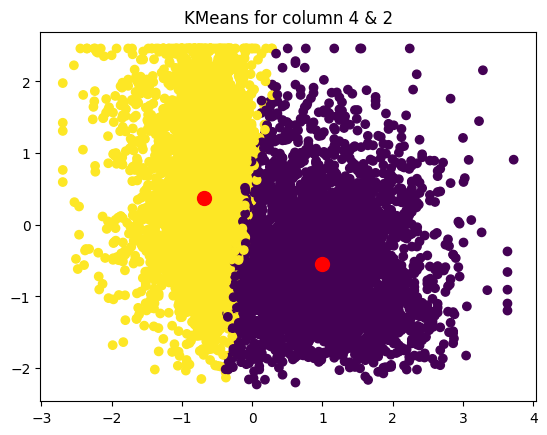

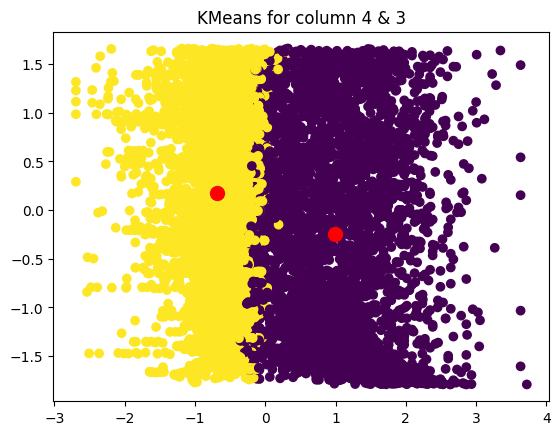

{'Calinski-Harabasz': 7867.875883108018,
 'Jaccard': 0.07771022693071691,
 'Rand': 0.7531403723319764,
 'Silhouette': 0.39526862497726367}


In [24]:
kmeans = KMeans(n_clusters=2).fit(Xc)
for i in range(2, 5):
    for j in range(2, i):
        plt.title(f'KMeans for column {i} & {j}')
        plt.scatter(Xc[:,i], Xc[:,j], c=kmeans.labels_)
        plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,j], s=100, c='red')
        plt.show()

models['KMeans'] = metrics(Xc, yc, kmeans.fit_predict(Xc))
pprint(metrics(Xc, yc, kmeans.labels_))

#### иерархическая кластеризация

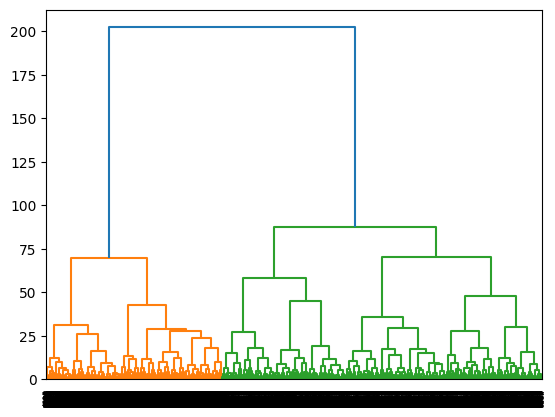

In [25]:
dendrogram = hierarchy.dendrogram(hierarchy.linkage(Xc, method="ward"))
plt.show()

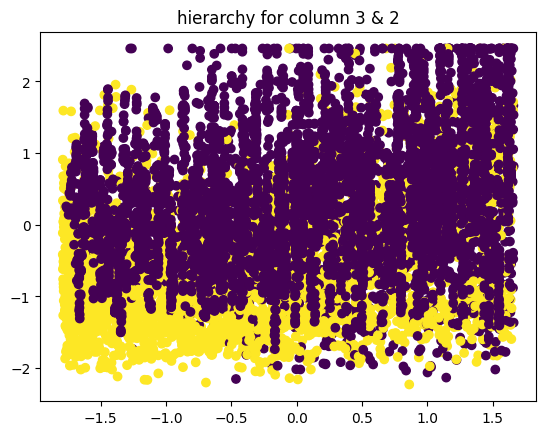

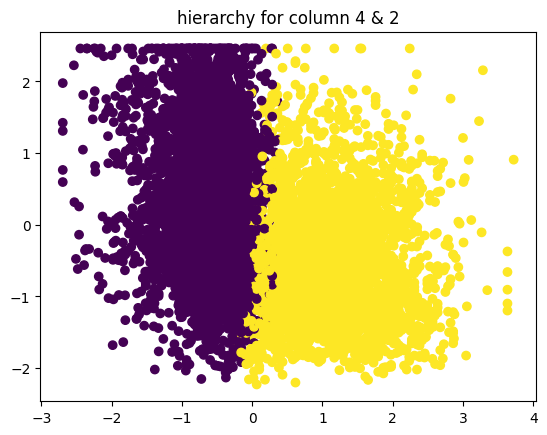

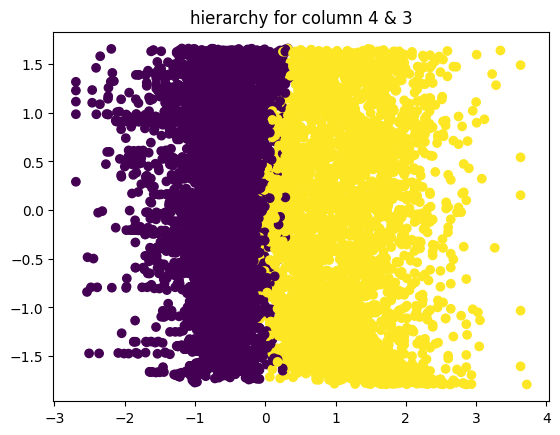

{'Calinski-Harabasz': 7553.291166360591,
 'Jaccard': 0.07861919392734502,
 'Rand': 0.7509193634811873,
 'Silhouette': 0.3981580690358137}


In [26]:
AC = AgglomerativeClustering(n_clusters=2, linkage="ward").fit(Xc)
for i in range(2, 5):
    for j in range(2, i):
        plt.title(f'hierarchy for column {i} & {j}')
        plt.scatter(Xc[:,i], Xc[:,j], c=AC.labels_)
        plt.show()

models['hierarchy'] = metrics(Xc, yc, AC.fit_predict(Xc))
pprint(metrics(Xc, yc, AC.fit_predict(Xc)))

#### DBSCAN

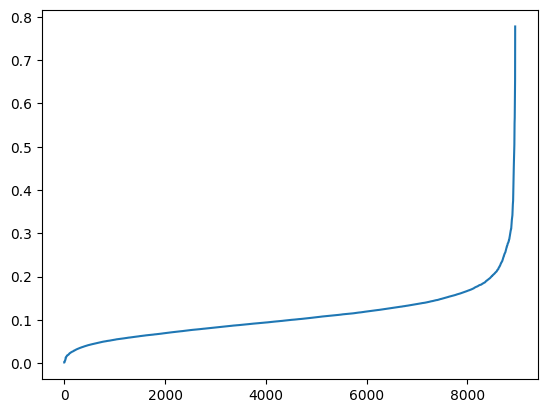

In [27]:
nbrs = NearestNeighbors(n_neighbors=4).fit(Xc)
distances, indices = nbrs.kneighbors(Xc)
distances = np.sort(np.mean(distances, axis=1))
plt.plot(distances)
plt.show()

In [37]:
ss = [] 
for min_s in range(26,41):
    try:
        res = (silhouette_score(Xc, DBSCAN(eps=0.2, min_samples=min_s).fit(Xc).labels_), min_s)
        ss.append(res)
        print(res)
    except ValueError:
        print(min_s)
    
print(max(ss))

(-0.4533306260950763, 26)
(-0.34533945386304443, 27)
(0.050416552481405294, 28)
(0.11827280430699887, 29)
(0.11813122316487125, 30)
(0.11985627012198555, 31)
(0.11268923617449689, 32)
(0.11183184549473339, 33)
(0.11109800872101246, 34)
(0.11141152219399678, 35)
(0.11141152219399678, 36)
(0.11138311546969999, 37)
(0.10819578403868482, 38)
(0.10819578403868482, 39)
(0.10819578403868482, 40)
(0.11985627012198555, 31)


[-1  0]


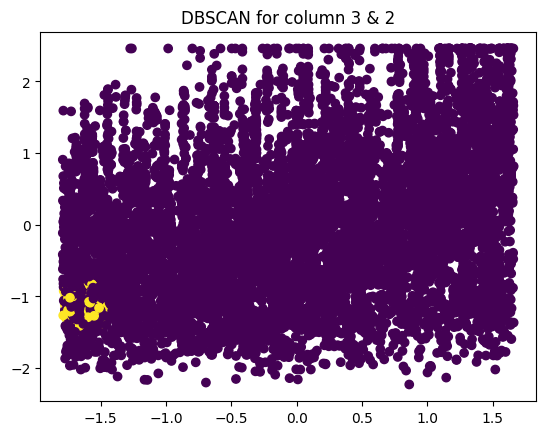

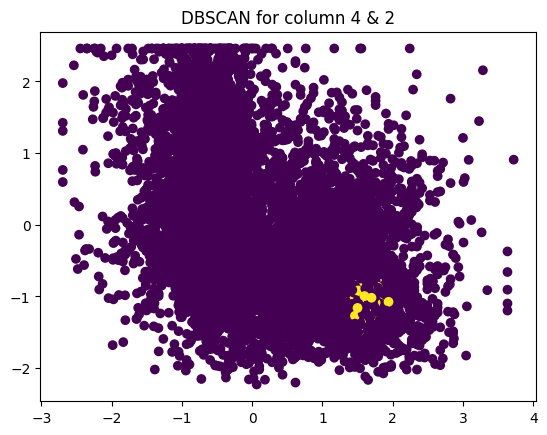

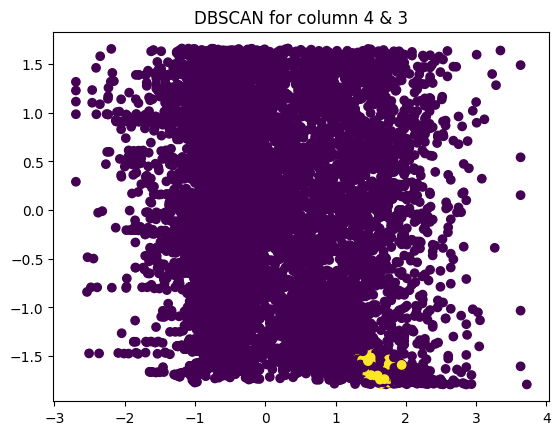

{'Calinski-Harabasz': 174.04738754243363,
 'Jaccard': 0.004882976932143459,
 'Rand': 0.5001330598555196,
 'Silhouette': 0.11985627012198555}


In [38]:
dbscan = DBSCAN(eps=0.2, min_samples=31).fit(Xc)
print(np.unique(dbscan.labels_))
for i in range(2, 5):
    for j in range(2, i):
        plt.title(f'DBSCAN for column {i} & {j}')
        plt.scatter(Xc[:,i], Xc[:,j], c=dbscan.labels_)
        plt.show()

models['DBSCAN'] = metrics(Xc, yc, dbscan.labels_)
pprint(metrics(Xc, yc, dbscan.labels_))

### 2. Произвести визуализацию построенных моделей.

### 3. Выполнить оценку качества полученных моделей кластеризации. Сравнить полученные результаты.

In [39]:
pprint(models)

{'DBSCAN': {'Calinski-Harabasz': 174.04738754243363,
            'Jaccard': 0.004882976932143459,
            'Rand': 0.5001330598555196,
            'Silhouette': 0.11985627012198555},
 'KMeans': {'Calinski-Harabasz': 7867.875883108018,
            'Jaccard': 0.07771022693071691,
            'Rand': 0.7531403723319764,
            'Silhouette': 0.39526862497726367},
 'hierarchy': {'Calinski-Harabasz': 7553.291166360591,
               'Jaccard': 0.07861919392734502,
               'Rand': 0.7509193634811873,
               'Silhouette': 0.3981580690358137}}


## ЗАДАНИЕ №3*. Реализовать алгоритма DBSCAN и с его помощью провести кластеризацию всех датасетов Лаб_работы №6.

In [31]:
def Dbscan(X, eps, min_samples):
    # Инициализация меток кластеров
    labels = np.zeros(len(X))
    cluster_id = 0

    for i in range(len(X)):
        # Если точка уже была помечена как часть кластера, пропускаем ее
        if labels[i] != 0:
            continue

        # Находим соседей текущей точки
        neighbors = find_neighbors(X, i, eps)

        # Если соседей меньше, чем min_samples, помечаем точку как выброс
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            cluster_id += 1
            expand_cluster(X, labels, i, neighbors, cluster_id, eps, min_samples)

    return labels

def expand_cluster(X, labels, point_index, neighbors, cluster_id, eps, min_samples):
    # Помечаем текущую точку как часть кластера
    labels[point_index] = cluster_id

    # Последовательно добавляем соседей кластера
    queue = list(neighbors)

    while queue:
        # Берем первую точку из очереди
        current_point = queue[0]
        del queue[0]

        if labels[current_point] == -1:
            # Если точка была помечена как выброс ранее, помечаем ее как часть кластера
            labels[current_point] = cluster_id

        elif labels[current_point] == 0:
            # Если точка еще не принадлежит кластеру
            labels[current_point] = cluster_id

            # Находим соседей текущей точки
            current_neighbors = find_neighbors(X, current_point, eps)

            # Если число соседей больше или равно min_samples, добавляем их в очередь
            if len(current_neighbors) >= min_samples:
                queue.extend(current_neighbors)

def find_neighbors(X, point_index, eps):
    # Вычисляем евклидово расстояние между текущей точкой и остальными точками
    distances = euclidean_distances(X[point_index].reshape(1, -1), X)[0]

    # Находим индексы точек, расстояние до которых меньше или равно eps
    neighbors = np.where(distances <= eps)[0]

    return neighbors


[-1.  1.  2.  3.]


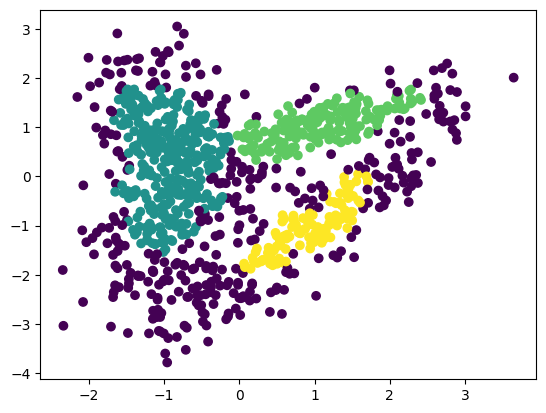

{'Calinski-Harabasz': 162.58610523400418,
 'Jaccard': 0.010622154779969651,
 'Rand': 0.6321973275881092,
 'Silhouette': 0.19158991995594316}
custom:↑    origin:↓
{'Calinski-Harabasz': 162.58610523400418,
 'Jaccard': 0.33111259160559625,
 'Rand': 0.6321973275881092,
 'Silhouette': 0.19158991995594316}
[-1.  1.  2.  3.]


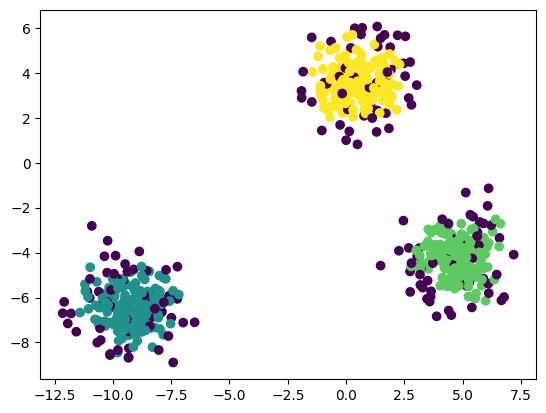

{'Calinski-Harabasz': 528.5140533780933,
 'Jaccard': 0.3227408142999007,
 'Rand': 0.827763101447312,
 'Silhouette': 0.4088755841973317}
custom:↑    origin:↓
{'Calinski-Harabasz': 528.5140533780933,
 'Jaccard': 0.0,
 'Rand': 0.827763101447312,
 'Silhouette': 0.4088755841973317}
[-1.  1.]


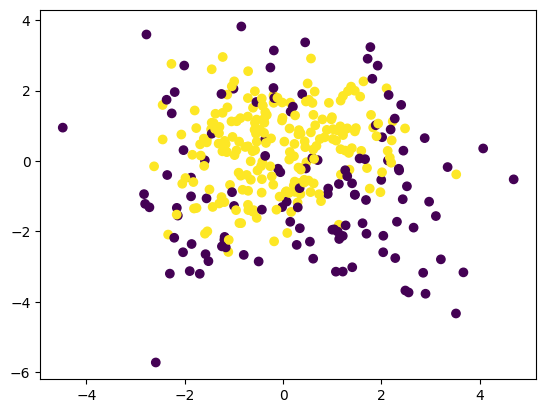

{'Calinski-Harabasz': 12.435845324805866,
 'Jaccard': 0.09180327868852459,
 'Rand': 0.48344730272441117,
 'Silhouette': 0.13086159670724354}
custom:↑    origin:↓
{'Calinski-Harabasz': 12.435845324805866,
 'Jaccard': 0.09539473684210527,
 'Rand': 0.48344730272441117,
 'Silhouette': 0.13086159670724354}


In [32]:
min_samples = (10, 6, 6)
for i in range(3):
    dbscan = Dbscan(eps=eps[i], min_samples=min_samples[i], X=X[i])
    print(np.unique(dbscan))
    plt.scatter(X[i][:,0], X[i][:,1], c=dbscan)
    plt.show()

    pprint(metrics(X[i], y[i], dbscan))
    print('custom:↑    origin:↓')
    pprint(methods[i]['DBSCAN'])